# 機械学習を使った因果推定

In [64]:
import random
import scipy
import pandas as pd
import numpy as np
from dfply import *
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

In [54]:
def make_ps_score_data(X_data, z_data):

    model = LogisticRegression(
        penalty='l1', 
        max_iter=10000,
        solver='liblinear',
        random_state=42
    )
    model.fit(X_data, z_data)

    ps_score_data = pd.DataFrame({
        'z': z_data, 
        'ps_score': model.predict_proba(X_data)[:, 1]
    })
    return ps_score_data

In [55]:
def plot_smd_data(adjust_smd_data, unadjust_smd_data, covariate_balance_threshold):
    
    smd_data = adjust_smd_data >> mutate(
        type='Adjusted'
    ) >> bind_rows(
        unadjust_smd_data >> mutate(
            type='Unadjusted'
        )
    )

    plot_data = smd_data >> arrange(X.colname, ascending=False)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x='smd',
        y='colname',
        hue='type',
        data=plot_data
    )

    plot_data = plot_data >> distinct(X.colname) >> mutate(
        threshold=covariate_balance_threshold
    )
    plt.plot(
        plot_data['threshold'].tolist(),
        plot_data['colname'].tolist(),
        linestyle='dashdot',
        linewidth=1.2,
        color='grey'
    )
    plt.xlabel('Standard Mean Differences')
    plt.yticks(fontsize=14, fontweight='bold')
    plt.ylabel('')
    plt.xlim(0, 3)
    plt.tight_layout()

In [56]:
def calc_smd_data_matching(target_data):
    
    smd_data = target_data >> group_by(X.z, X.colname) >> summarise(
        n=X.value.count(),
        value_mean=X.value.mean(),
        value_std=X.value.std()
    ) >> mutate(
        std_2_n=(X.n-1)*X.value_std*X.value_std
    )
    
    smd_data = smd_data >> group_by(X.colname) >> summarise(
        mean_diff=X.value_mean.diff().values[1]
    ) >> mutate(
        mean_diff=X.mean_diff.abs()
    ) >> left_join(
        smd_data >> group_by(X.colname) >> summarise(
            s=X.std_2_n.sum()/(X.n.sum() - 2)
        ) >> mutate(
            s=X.s.apply(lambda x: np.sqrt(x))
        ), by='colname'
    ) >> mutate(
        smd=X.mean_diff/X.s
    )
    smd_data.fillna(0, inplace=True)
    
    return smd_data

In [57]:
def plot_covariate_balance_matching(target_data, matched_ps_data, z_name, covariate_balance_threshold=0.1):
    
    adjust_data = target_data.rename(columns={z_name : 'z'}).copy()
    adjust_data['index_all'] = adjust_data.index
    adjust_data = adjust_data >> rename(
        index_treatment=X.index_all
    ) >> semi_join(
        matched_ps_data, by='index_treatment'
    ) >> select(~X.index_treatment) >> bind_rows(
        adjust_data >> rename(
            index_control=X.index_all
        ) >> semi_join(
            matched_ps_data, by='index_control'
        ) >> select(~X.index_control)
    ) >> select(['z'] + x_names)

    adjust_data = adjust_data.set_index('z')
    adjust_data = adjust_data.stack()
    adjust_data = adjust_data.reset_index(drop=False)
    adjust_data.columns = ['z', 'colname', 'value']

    unadjust_data = target_data.rename(columns={z_name : 'z'}).copy()
    unadjust_data = unadjust_data >> select(['z'] + x_names)

    unadjust_data = unadjust_data.set_index('z')
    unadjust_data = unadjust_data.stack()
    unadjust_data = unadjust_data.reset_index(drop=False)
    unadjust_data.columns = ['z', 'colname', 'value']

    adjust_smd_data = calc_smd_data_matching(adjust_data)
    unadjust_smd_data = calc_smd_data_matching(unadjust_data)

    plot_smd_data(
        adjust_smd_data=adjust_smd_data,
        unadjust_smd_data=unadjust_smd_data,
        covariate_balance_threshold=covariate_balance_threshold
    )

In [58]:
def get_matched_propensity_score(target_data, y_name, z_name, x_names, threshold=0.2, 
                                 flag_covariate_barance=True, covariate_balance_threshold=0.1):
    
    
    ps_score_data = make_ps_score_data(
        X_data = target_data >> select(x_names),
        z_data = target_data[z_name]
    )
    ps_score_data['index_all'] = target_data.index
    ps_score_data['y'] = target_data[y_name]
    

    treatment_data = ps_score_data >> filter_by(X.z == 1) >> rename(
        index_treatment=X.index_all
    )
    treatment_data.reset_index(inplace=True, drop=True)
    control_data = ps_score_data >> filter_by(X.z == 0) >> rename(
        index_control=X.index_all
    )
    control_data.reset_index(inplace=True, drop=True)


    match_index_data = pd.DataFrame()
    treatment_data_tmp = treatment_data.copy()
    control_data_tmp = control_data.copy()


    while len(treatment_data_tmp) > 0 and len(control_data_tmp) > 0:

        neigh = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
        neigh.fit(control_data_tmp['ps_score'].values.reshape(-1, 1))
        distances, indices = neigh.kneighbors(treatment_data_tmp['ps_score'].values.reshape(-1, 1))

        distance_data = pd.DataFrame({
            'distance': distances.reshape(-1), 
            'index_treatment': treatment_data_tmp['index_treatment'].values,
            'index_control' : control_data_tmp['index_control'][indices.reshape(-1)]
        }) >> filter_by(X.distance <= threshold) >> arrange(X.distance) >> distinct(X.index_control)

        if len(distance_data) == 0:
            break

        match_index_data = match_index_data >> bind_rows(
            distance_data >> select(X.index_treatment, X.index_control, X.distance)
        )

        treatment_data_tmp = treatment_data_tmp >> anti_join(distance_data, by='index_treatment')
        control_data_tmp = control_data_tmp >> anti_join(distance_data, by='index_control')

        treatment_data_tmp.reset_index(inplace=True, drop=True)
        control_data_tmp.reset_index(inplace=True, drop=True)

        
    match_index_data = match_index_data >> arrange(X.index_treatment)
    match_index_data.reset_index(inplace=True, drop=True)

    matched_ps_data = match_index_data >> left_join(
        ps_score_data >> rename(
            y_treatment=X.y,
            ps_score_treatment=X.ps_score,
            index_treatment=X.index_all
        ) >> select(
            X.index_treatment, X.y_treatment, X.ps_score_treatment
        ), by='index_treatment' 
    ) >> left_join(
        ps_score_data >> rename(
            y_control=X.y,
            ps_score_control=X.ps_score,
            index_control=X.index_all
        ) >> select(
            X.index_control, X.y_control, X.ps_score_control
        ), by='index_control' 
    ) >> mutate(y_diff=X.y_treatment-X.y_control)
    
    
    target_data_lr = matched_ps_data >> select(X.y_treatment) >> mutate(z=1) >> rename(
        y=X.y_treatment
    ) >> bind_rows(
        matched_ps_data >> select(X.y_control) >> mutate(z=0) >> rename(
            y=X.y_control
        )
    )
    X_data = target_data_lr >> select('z')
    X_data = sm.add_constant(X_data)
    
    model = sm.OLS(target_data_lr['y'], X_data)

    results = model.fit()
    results = results.summary()
    
    if flag_covariate_barance:
        plot_covariate_balance_matching(
            target_data=target_data.copy(),
            matched_ps_data=matched_ps_data.copy(),
            z_name=z_name,
            covariate_balance_threshold=covariate_balance_threshold
        )
    
    return results, matched_ps_data

## データの作成

In [23]:
game_data = pd.read_csv('https://raw.githubusercontent.com/iwanami-datascience/vol3/master/kato%26hoshino/q_data_x.csv')

In [27]:
game_data.head()

,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,job_dummy2,job_dummy3,job_dummy4,job_dummy5,job_dummy6,job_dummy7,job_dummy8,inc,pmoney,fam_str_dummy1,fam_str_dummy2,fam_str_dummy3,fam_str_dummy4,fam_str_dummy5,child_dummy,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
0,0,0,0,0,0,1,44.5,1,1,1,0,0,0,0,0,0,0,249.5,0.0,0,0,1,0,0,1,0,0,0,0,0,1,0,33.427600,0,0
1,0,0,0,1,0,0,34.5,1,1,1,0,0,0,0,0,0,0,800.0,12.5,0,0,1,0,0,1,0,0,0,0,0,1,0,31.542862,0,0
2,0,0,0,1,0,0,24.5,1,0,0,0,0,0,0,0,1,0,0.0,2.0,0,0,0,1,0,0,0,0,0,0,1,0,0,37.825805,0,0
3,0,0,0,1,0,0,44.5,1,1,1,0,0,0,0,0,0,0,800.0,2.0,0,0,1,0,0,1,0,0,0,0,0,1,0,36.345911,0,0
4,0,0,0,1,0,0,34.5,1,1,1,0,0,0,0,0,0,0,749.5,4.0,0,0,1,0,0,1,0,0,0,0,1,0,0,49.344942,0,0


## データの加工

In [88]:
Y_data = game_data['gamesecond']
Z_data = game_data['cm_dummy']
X_data = game_data.drop(columns=['gamesecond', 'cm_dummy', 'gamecount'])

X_data_0 = X_data[Z_data == 0]
Y_data_0 = Y_data[Z_data == 0]
X_data_1 = X_data[Z_data == 1]
Y_data_1 = Y_data[Z_data == 1]

## T-learner

In [41]:
max_depth = 6

In [42]:
model_0 = xgb.XGBRegressor(max_depth=max_depth)
model_0.fit(X_data_0], Y_data_0)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
model_1 = xgb.XGBRegressor(max_depth=max_depth)
model_1.fit(X_data_1, Y_data_1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### ATEを求める

In [44]:
predict_values0 = model_0.predict(X_data)
predict_values1 = model_1.predict(X_data)

print('ATE : {}, std : {}'.format(
    (predict_values1 - predict_values0).mean(),
    (predict_values1 - predict_values0).std(),
))

ATE : -1144.0826416015625, std : 15165.9248046875


In [46]:
atts = Y_data_1 - model_0.predict(X_data_1)

print('ATE : {}, std : {}'.format(
    atts.mean(),
    atts.std()
))

ATE : -387.47368245498495, std : 14073.463144163057


In [47]:
atus = model_1.predict(X_data_0) - Y_data_0

print('ATE : {}, std : {}'.format(
    atus.mean(),
    atus.std()
))

ATE : -1679.4995263339647, std : 15874.50890761007


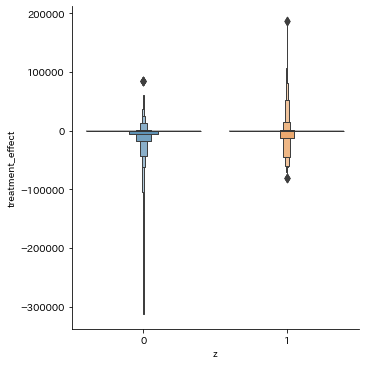

In [53]:
plot_data = pd.DataFrame({
    'z' : Z_data,
    'treatment_effect' : model_1.predict(X_data) - model_0.predict(X_data)
})

sns.catplot(
    data=plot_data,
    x='z',
    y='treatment_effect',
    kind='boxen'
)

## S-leaner

In [82]:
model = xgb.XGBRegressor(max_depth=max_depth)
model.fit(pd.concat([X_data, Z_data], axis=1), Y_data)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [84]:
X_1 = X_data.copy()
X_1['cm_dummy'] = 1
X_0 = X_data.copy()
X_0['cm_dummy'] = 0

treatment_effects = model.predict(X_1) - model.predict(X_0)

print('ATE : {}, std : {}'.format(
    treatment_effects.mean(),
    treatment_effects.std()
))

ATE : -645.392578125, std : 2756.917724609375


## X-Learner

In [93]:
model_0 = xgb.XGBRegressor(max_depth=max_depth)
model_0.fit(X_data_0, Y_data_0)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [90]:
model_1 = xgb.XGBRegressor(max_depth=max_depth)
model_1.fit(X_data_1, Y_data_1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [94]:
tau_0 = model_1.predict(X_data_0) - Y_data_0
tau_1 = Y_data_1 - model_0.predict(X_data_1)

In [95]:
model_tau_0 = xgb.XGBRegressor(max_depth=max_depth)
model_tau_0.fit(X_data_0, tau_0)

model_tau_1 = xgb.XGBRegressor(max_depth=max_depth)
model_tau_1.fit(X_data_1, tau_1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [98]:
log = LogisticRegression()
log.fit(X_data, Z_data)
ps_scores = log.predict_proba(X_data)[:, 1]

In [100]:
tau = ps_scores * model_tau_0.predict(X_data) + (1-ps_scores) * model_tau_1.predict(X_data)

In [102]:
print('ATE : {}, std : {}'.format(
    tau.mean(),
    tau.std()
))

ATE : -1074.4562666515126, std : 10597.226774006378


In [114]:
model_0 = xgb.XGBRegressor(max_depth=max_depth)
model_0.fit(X_data_0, Y_data_0)

model_1 = xgb.XGBRegressor(max_depth=max_depth)
model_1.fit(X_data_1, Y_data_1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [116]:
logit = LogisticRegression()
logit.fit(X_data, Z_data)
ps_scores = logit.predict_proba(X_data)

In [117]:
Y_1 = model_1.predict(X_data_1) + (
    Y_data_1 - model_1.predict(X_data_1)
) / logit.predict_proba(X_data_1)[:, 1]

In [105]:
from causalml.inference.meta import BaseXRegressor, BaseSRegressor, BaseTRegressor

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [109]:
learner_x = BaseXRegressor(learner=xgb.XGBRegressor(random_state=42))

In [110]:
learner_x.fit(
    X=X_data,
    treatment=Z_data,
    y=Y_data
)

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     7.501
Date:                Fri, 20 Nov 2020   Prob (F-statistic):            0.00619
Time:                        21:25:02   Log-Likelihood:                -64189.
No. Observations:                5824   AIC:                         1.284e+05
Df Residuals:                    5822   BIC:                         1.284e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3332.0144    274.345     12.145      0.000    2794.197    3869.832
z          -1062.5687    387.982     -2.739      0.006   -1823.158    -301.980
==============================================================================
Omnibus:                     7232.949   Durbin-Watson:                   1.223
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           781067.241
Skew:                           6.940   Prob(JB):                         0.00
Kurtosis:                      58.009   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

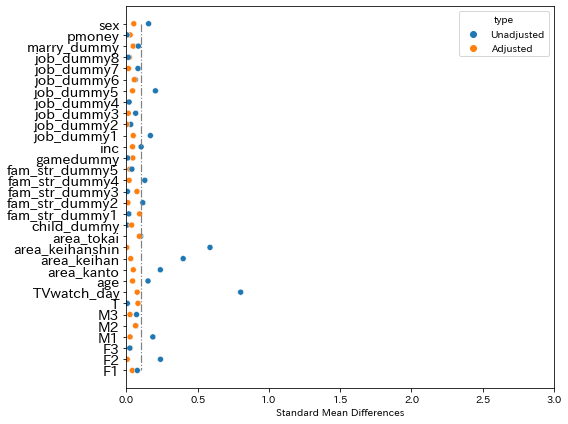

In [65]:
target_data = game_data.copy()

y_name = 'gamesecond'
z_name = 'cm_dummy'
x_names = X_data.columns.tolist()

results, matched_ps_data = get_matched_propensity_score(
    target_data=target_data.copy(),
    y_name=y_name,
    z_name=z_name,
    x_names=x_names,
    threshold=0.2,
    flag_covariate_barance=True,
    covariate_balance_threshold=0.1
)

results